# Gaussian Process Latent Variable Model

Open processed video sample using OpenCV library:

In [1]:
import numpy as np
import cv2

w,h = 120,90

sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 116.  121.  130. ...,  109.   67.   65.]


Function for displaying one frame:

In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((h,w)),cmap='Greys_r')

Plot the first frame of sample:

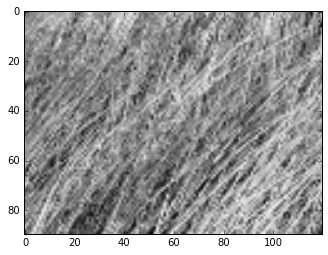

In [3]:
import matplotlib.pyplot as mp

% matplotlib inline
show_frame(sample[0,:])

Initialize all the parameters and normilize given sample:

In [4]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample, 0)
sample_std = np.std(sample, 0)
sample = (sample - sample_mean)/sample_std # normalization

print(sample)

[[-1.11651213 -1.01944808 -0.23999337 ..., -0.12147499 -1.15733176
  -1.52699203]
 [-0.28189271 -0.92650059 -0.3284865  ...,  0.78656064 -0.78029405
   1.12758945]
 [ 0.39623557 -0.8335531  -0.01876054 ...,  1.19013202  0.17680168
   3.23846147]
 ..., 
 [-2.1597864   0.14239556 -0.85944528 ...,  0.3493583  -0.72228825
   1.03164073]
 [ 1.49167355 -0.36881564 -1.25766437 ...,  0.08031071  0.98888291
   0.10413635]
 [-0.54271128  1.86192413 -0.90369185 ...,  1.02197728  0.5538394
  -0.27965856]]
[ 137.404  142.936  135.424 ...,  112.612  106.904  112.744]
[ 19.17041429  21.51752551  22.60062442 ...,  29.73451624  34.47930951
  31.26669896]


Define combined kernel using GPy library:

In [5]:
import GPy

#kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
kernel = GPy.kern.RBF(Q,ARD=True)
m = GPy.models.GPLVM(sample, input_dim=Q, kernel=kernel, init='PCA')

Optimization of the model using SCG (Warning! Minimum value for max_iters is 100, for 10000 it takes around 1 hour to perform optimization)

In [6]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=100)

Extract latent X from the model:

In [ ]:
X = m.X
print(X)

In [ ]:
# Save data to tmp file
#np.save('test_X', X)

Plot first 5 values to visualize:

In [ ]:
mp.plot(X[:,0:5])

Extract kernel matrix:

In [ ]:
Kx = kernel.K(X[0:N-1])
print(Kx)

Function to predict new artificial frame using mean prediction method:

In [ ]:
def predict_new_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

Perform prediciton of new X:

In [ ]:
N_synt = N  #for evaluation - the same number as in the input
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

Plot of new X:

In [ ]:
mp.plot(X_synt)

In [ ]:
# Save data to tmp file
#np.save('test_X_synt', X_synt)

Now perform syntesis of the dinamic texture based on new X by using multivariate Gaussian:

In [ ]:
Y_synt = np.zeros((N_synt,D))

kernel2 = kernel #GPy.kern.RBF(Q,ARD=True) #try original kernel
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample)


    
k_y = kernel2.K(X,X_synt)
k_yy = kernel2.K(X_synt,X_synt)
meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))


for i in range(D):
    Y_synt[:,i] = np.matmul(cov,np.random.randn(N_synt)) + meann[i,:]

print(Y_synt)

In [ ]:
# Save data to tmp file
#np.save('test_Y_synt', Y_synt)

Display first frame:

In [ ]:
show_frame(Y_synt[1,:])
print(Y_synt[1,1:5])

In [ ]:
frame = Y_synt_denorm[i,:].reshape((h,w)).astype(np.uint8)
show_frame(frame)
print(frame)

Finally, save video:

### 0. Save as pictures

In [ ]:
for i in range(N_synt):
    print(i)
    frame = Y_synt[i,:].reshape((h,w)).astype(int)
    ind = 'frame' + str(i) + '.jpg'
    mp.imsave(ind,frame,cmap='Greys_r')

cv2.destroyAllWindows()
print('Done!')

### 1. Save as pictures using global normalization

In [ ]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()

Y_synt_denorm = (255/(max - min))*(Y_synt - min)
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)

In [ ]:
for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    
    ind = 'data/frame' + str(i) + '.jpg'
    mp.imsave(ind,frame,cmap='Greys_r')
    #img = mp.imread('data/test.png')
    
    #out.write(img)
    #print(img)

#cap.release()
#out.release()
cv2.destroyAllWindows()
print('Done!')

### 2. Global denormalization

In [ ]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

In [ ]:
Y_synt_denorm = (255/(max - min))*(Y_synt - min)
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)

In [ ]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output2.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

### 3. Denormalization of every frame independently

In [ ]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

In [ ]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output3.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min)
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

### 4. Global denormalization using mean and std from initialization step

In [ ]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

In [ ]:
Y_synt_demorm = sample_std * Y_synt + sample_mean
max = Y_synt_demorm[:,:].max()
min = Y_synt_demorm[:,:].min()
print(min, max)

In [ ]:
# how to cut negative values?

In [ ]:
min.astype(np.uint8)

In [ ]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output4.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

### 5. Global denormalization + denormalization of every frame

In [ ]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

In [ ]:
Y_synt_denorm = (255/(max - min))*(Y_synt - min)
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)

In [ ]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output5.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min)    
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

### 6. Global denormalization + histogram equalization

In [ ]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

In [ ]:
Y_synt_denorm = (255/(max - min))*(Y_synt - min)
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)

In [ ]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output6.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(np.uint8)  
    equ = cv2.equalizeHist(frame)
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = equ
    img[:,:,1] = equ
    img[:,:,2] = equ
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

### 7. Global denormalization + denormalize every frame + histogram equalization

In [ ]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

In [ ]:
Y_synt_denorm = (255/(max - min))*(Y_synt - min)
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)

In [ ]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output7.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min)    
    frame = frame.astype(np.uint8)  
    equ = cv2.equalizeHist(frame)
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = equ
    img[:,:,1] = equ
    img[:,:,2] = equ
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')